# Aspect-Based Sentiment Analysis with BERT

In this lab we turn a pre-trained BERT model into a trainable NN layer and apply it to the Aspect-Based Sentiment Analysis (ABSA). You can find the task description from (https://aclanthology.org/D19-1654.pdf).
This task provides a review text dataset with aspects.
Given a review and an aspect, we need to classify the sentiment conveyed towards this aspect on a three-point scale: POSITIVE, NEUTRAL or NEGATIVE.
This is a multi-class classification task.

BERT (Bidirectional Embedding Representations from Transformers) is a model for pre-training language representations that obtains state-of-the-art results on many NLP tasks. We demonstrate how to integrate BERT as a custom NN layer using the Huggingface library.

In this lab, you will learn:

1) How to use the Huggingface library.

2) How to integrate BERT in the models built previously.

3) How to use the GPU from Colab. **Note**: Running BERT on the CPU will be very slow. Thus we recommend you to do this lab on a Colab GPU provided by Google.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We first need to install the Huggingface's Transformers package. You can find the relevant doc from [here](https://huggingface.co/transformers/index.html).

In [2]:
!pip install transformers

## Preprocessing and Tokenization

In this lab we will use DistilBERT (https://arxiv.org/pdf/1910.01108.pdf) instead of BERT: DistilBERT is a smaller and faster Transformer model trained via distilling BERT. It has 40% less parameters than the bert-base-uncased model. It runs 60% faster, while preserving 97% of BERT’s performance as measured on the GLUE language understanding benchmark.

It is easy to switch between DistilBERT and BERT using the Huggingface transformers package. This package provides many pre-trained and pre-built models that are easy to use via a few lines of code.

Before using DistilBERT or BERT, we need a tokenizer. Generally speaking, every BERT related model has its own tokenizer, trained for this particular model.
We can get the DistilBERT tokenizer from the **DistilBertTokenizer.from_pretrained** method.

In [3]:
from transformers import DistilBertTokenizer, RobertaTokenizer
import tqdm
distil_bert = 'distilbert-base-uncased' # Pick a pre-trained model

# Defining DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, max_length=128, pad_to_max_length=True)

def tokenize(sentences, tokenizer, pad_length=128, pad_to_max_length=True):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        return inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids']

    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return input_ids, input_masks, input_segments

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
inputs = tokenizer.tokenize("The capital of France is [MASK].")
print(inputs,'\n')

inputs = tokenizer.tokenize("This is a pretrained model.")
print(inputs,'\n')

ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")

ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer, pad_to_max_length=False)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['the', 'capital', 'of', 'france', 'is', '[MASK]', '.'] 

['this', 'is', 'a', 'pre', '##train', '##ed', 'model', '.'] 

[101, 1996, 3007, 1997, 2605, 2003, 103, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['[CLS]', 'the', 'capital', 'of', 'france', 'is', '[MASK]', '.', '[SEP]', '[PAD]', '[P

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Then we can use this tokenizer to tokenize our data. When working with word2vec and GloVe, you tokenized sentences into words yourself and then converted the tokens into GloVe indices. But in BERT, we must use the BERT tokenizer that uses sub-word tokens.

For example, for the sentence: **This is a pretrained model.** our previous word-based tokenizer will generate the following tokens:

**"this", "is", "a", "pretrained", "model", "."**

Then you will find out that the token "pretrained" is not in the GloVe word dictionary. Thus we can not assign it a trained word vector.

The BERT tokenizer will separate the word "pretrained" into three sub-word tokens:

**'pre', '##train', '##ed'**

BERT thus uses these three token vectors to represent the word "pretrained". You will also see that the BERT tokenizer adds the special [CLS] token and the sentence separator [SEP] token.

## Loading Data

### Downloading and preprocessing data

Unlike the IMDB dataset that is included and preprocessed, the dataset we will be using is the aspect-based sentiment analysis (ABSA)  dataset, which consists of 5,297 labeled reviews. These are split into 4,297 reviews for training and 500 reviews for testing and validation, respectively.

For ABSA, sentiment polarities were assigned with respect to the aspect terms.  The start and end positions for each aspect term are provided.


In [5]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/train.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/val.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/test.xml')


# The code is modified from https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data_process/utils.py
from xml.etree.ElementTree import parse

def parse_sentence_term(path, lowercase=False):
    tree = parse(path)
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = [text , term,  polarity , start , end]
            data.append(piece)
    return data
train = parse_sentence_term("train.xml",True)
dev = parse_sentence_term("val.xml",True)
test = parse_sentence_term("test.xml",True)

print("Training entries: {}".format(len(train)))
print("Test entries: {}".format(len(test)))


Training entries: 11186
Test entries: 1336


Let’s first see some examples from the data:

In [6]:
print("SENTENCE \t ASPECT \t LABEL \t ASPECT-START-INDEX \t ASPECT-END-INDEX")
print(train[0])
print(train[1])
print(train[2])
print(train[3])
print(train[4])

SENTENCE 	 ASPECT 	 LABEL 	 ASPECT-START-INDEX 	 ASPECT-END-INDEX
['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
['when tables opened up, the manager sat another party before us.', 'manager', 'negative', '27', '34']


We one-hot encode the labels, using 100 to represent "positive", 010 for "neutral", and 001 for "negative".

In [7]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append([0,0,1])
    elif example[2].lower() == "neutral":
      y.append([0,1,0])
    else:
      # assert example[2].lower() == "positive"
      y.append([1,0,0])
  return y

y_train = label2int(train)
y_dev = label2int(dev)
y_test = label2int(test)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

[0 0 1]
[1 0 0]
[1 0 0]
[0 1 0]
[0 0 1]


Now we have almost finished the data preprocessing. Unlike in the previous labs, there are two model inputs: review and aspect. The easiest way is to combine the review and aspect into one sentence and then input it into the model.

In [8]:
"""
Task 1: Data pre-processing

Begin
"""

# Please write your code to combine sentences and aspect words into the following varibles

# x_train_int
# x_train_masks
# x_dev_int
# x_dev_masks
# x_test_int
# x_test_masks
# Tips:
# 1) Use the special token [SEP] to concatenate sentences and aspect words
# 2) Make sure they are paded/truncated to a max length
# Function to tokenize review + aspect
def preprocess(dataset, tokenizer, pad_length=128):
    input_ids, attention_masks = [], []

    for row in dataset:
        review = row[0]
        aspect = row[1]

        #combine review and aspect using the [SEP] token
        combined_row = review + " [SEP] " + aspect
        #print(combined_row)
        #tokenizing using DistilBERT
        tokenized_row = tokenizer.encode_plus(combined_row, add_special_tokens=True,
                                       max_length=pad_length, padding='max_length',
                                       truncation=True, return_attention_mask=True)

        input_ids.append(tokenized_row['input_ids'])
        attention_masks.append(tokenized_row['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

#applying preprocessing and tokenization to train, dev, and test sets

x_train_int, x_train_masks = preprocess(train, tokenizer)
x_dev_int, x_dev_masks = preprocess(dev, tokenizer)
x_test_int, x_test_masks = preprocess(test, tokenizer)



"""
End Task 1
"""

# Don't forget the to use the np.array function to wrap the outputs
x_train_int_np = np.array(x_train_int)
x_train_masks_np = np.array(x_train_masks)
x_dev_int_np = np.array(x_dev_int)
x_dev_masks_np = np.array(x_dev_masks)
x_test_int_np = np.array(x_test_int)
x_test_masks_np = np.array(x_test_masks)


print(x_dev_int[0])
print(x_dev_masks[0],'\n')
print(x_dev_int_np[0])
print(x_dev_masks_np[0]) # sentence + aspect



[  101  2044  1037  3232  1997  8974  1010  1996 18726  1011  1011  1045
  2066  1996 27940  1013 24792  2621  4897  1998  1996 13675 11514  6508
 26852  1011  1011  2175  2091  2307  1012   102  8974   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Model 1: Prebuilt Sequence Classification



The Huggingface transformer package provides many prebuilt models. Now let us try a sequence classification model based on DistilBERT.

The models with BERT are much bigger than our previous models. To run it faster, we can use GPU.

In [9]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig
import torch
import torch.nn as nn

distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(num_labels=3, max_length=128)
config.output_hidden_states = False

class DistilBertForSequenceClassificationWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer_model = DistilBertForSequenceClassification.from_pretrained(distil_bert, config=config)
        for name, param in self.transformer_model.named_parameters():
            param.requires_grad = True

        ### keep classifier trainable, freeze other layers
        # print("The following layers will be trainable:", end=" ")
        # for name, param in self.transformer_model.named_parameters():
        #     if 'classifier' in name:
        #         param.requires_grad = True
        #         print(name, end=", ")
        #     else:
        #         param.requires_grad = False
        # print()

        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        output = self.transformer_model(input_ids=input_ids, attention_mask=attention_mask)
        output = self.sigmoid(output.logits)
        return output

def create_DistilBertForSequenceClassification():
    return DistilBertForSequenceClassificationWrapper()


# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model and
model = create_DistilBertForSequenceClassification().to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Define loss function
criterion = nn.BCELoss()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
print(model)

DistilBertForSequenceClassificationWrapper(
  (transformer_model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): DistilBertSdpaAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-1

In [11]:
# define dataset
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_train_int_np).to(torch.int32), torch.tensor(x_train_masks_np).to(torch.int32), torch.tensor(y_train).to(torch.float)
    )
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_dev_int_np).to(torch.int32), torch.tensor(x_dev_masks_np).to(torch.int32), torch.tensor(y_dev).to(torch.float)
    )
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_test_int_np).to(torch.int32), torch.tensor(x_test_masks_np).to(torch.int32), torch.tensor(y_test).to(torch.float)
    )

In [12]:
# Training loop (example)
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, true_labels = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == true_labels).sum().item()
    return total_loss / len(train_loader), correct / total

# Evaluation function (example)
def evaluate(model, eval_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            _, true_labels = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == true_labels).sum().item()

    return total_loss / len(eval_loader), correct / total

In [13]:
epochs = 5
batch_size = 256

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=False)

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/5, Train Loss: 0.5660, Train Acc: 0.5145, Val Loss: 0.4053, Val Acc: 0.7372
Epoch 2/5, Train Loss: 0.3435, Train Acc: 0.7814, Val Loss: 0.3177, Val Acc: 0.8101
Epoch 3/5, Train Loss: 0.2428, Train Acc: 0.8577, Val Loss: 0.3141, Val Acc: 0.8116
Epoch 4/5, Train Loss: 0.1674, Train Acc: 0.9120, Val Loss: 0.3515, Val Acc: 0.8093
Epoch 5/5, Train Loss: 0.1130, Train Acc: 0.9452, Val Loss: 0.3636, Val Acc: 0.8146


In [14]:
# eval
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.3269, Test Acc: 0.8263


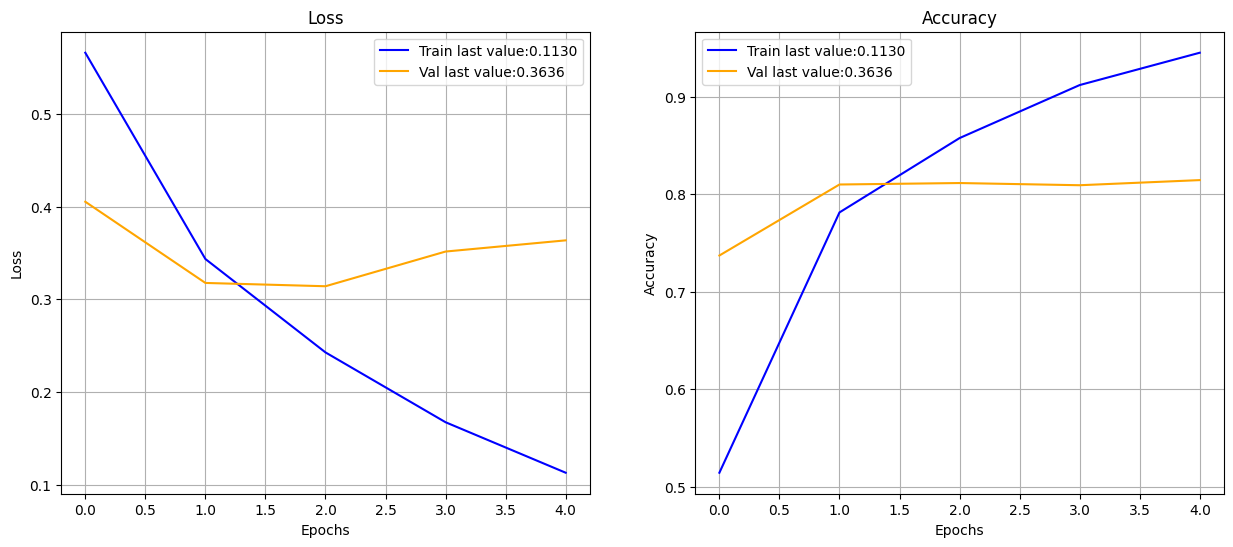

In [15]:
def plot_loss_acc_list():
  plt.figure(figsize=(15,6))
  index_list = [i for i in range(epochs)]

  plt.subplot(1,2,1)
  plt.grid()
  plt.plot(index_list, train_loss_list, 'blue', label=f'Train last value:{train_loss_list[-1]:.4f}')
  plt.plot(index_list, val_loss_list, 'orange', label=f'Val last value:{val_loss_list[-1]:.4f}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.grid()
  plt.plot(index_list, train_acc_list, 'blue', label=f'Train last value:{train_loss_list[-1]:.4f}')
  plt.plot(index_list, val_acc_list, 'orange', label=f'Val last value:{val_loss_list[-1]:.4f}')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy')
  plt.legend()
plot_loss_acc_list()


## Model 2: Neural bag of words using BERT

Now we want to build the neural network model. We  are going to have a hidden layer with 16 hidden units.

First, we want to transform each index to a BERT embedded vector and then average all vectors to a single one. It has been showed that unweighted average of word vectors outperforms many complicated networks that model semantic and syntactic compositionality. As an example you can take a look at this: (http://anthology.aclweb.org/P/P15/P15-1162.pdf)

To average we need to ignore padded zeros:

In [16]:
import gc
if 'model' in locals():
  del model
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [17]:
class GlobalAveragePooling1DMasked(nn.Module):
    def forward(self, x, mask=None):
        if mask is not None:
            return x.sum(dim=1) / mask.sum(dim=1, keepdim=True)
        else:
            return x.mean(dim=1)

In [18]:
from transformers import DistilBertModel, DistilBertConfig

config = DistilBertConfig(max_length=128, embedding_size=100)
config.output_hidden_states = False

class BagOfWordsBERT(nn.Module):
    def __init__(self, hdepth=16):
        super(BagOfWordsBERT, self).__init__()

        """
        Task 2: Basic classifiers using BERT

        Begin
        """

        self.bert =  DistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
        self.pooling = GlobalAveragePooling1DMasked()
        self.hidden_size = hdepth
        self.hidden = nn.Linear(768, self.hidden_size)
        self.output = nn.Linear(self.hidden_size, 3) #because we have 3 classes

        """
        End Task 2
        """

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
        pooled = self.pooling(bert_output, attention_mask)
        hidden = torch.sigmoid(self.hidden(pooled))
        output = self.output(hidden)
        return torch.softmax(output, dim=1)

# Create model
model = BagOfWordsBERT().to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)


In [19]:
print(model)

BagOfWordsBERT(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

In [20]:
epochs = 5
batch_size = 256

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=False)

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/5, Train Loss: 0.5785, Train Acc: 0.5156, Val Loss: 0.5038, Val Acc: 0.6779
Epoch 2/5, Train Loss: 0.4598, Train Acc: 0.7586, Val Loss: 0.4533, Val Acc: 0.7808
Epoch 3/5, Train Loss: 0.4156, Train Acc: 0.8301, Val Loss: 0.4334, Val Acc: 0.8056
Epoch 4/5, Train Loss: 0.3890, Train Acc: 0.8716, Val Loss: 0.4326, Val Acc: 0.8048
Epoch 5/5, Train Loss: 0.3685, Train Acc: 0.8981, Val Loss: 0.4182, Val Acc: 0.8191


In [21]:
# eval
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.4083, Test Acc: 0.8301


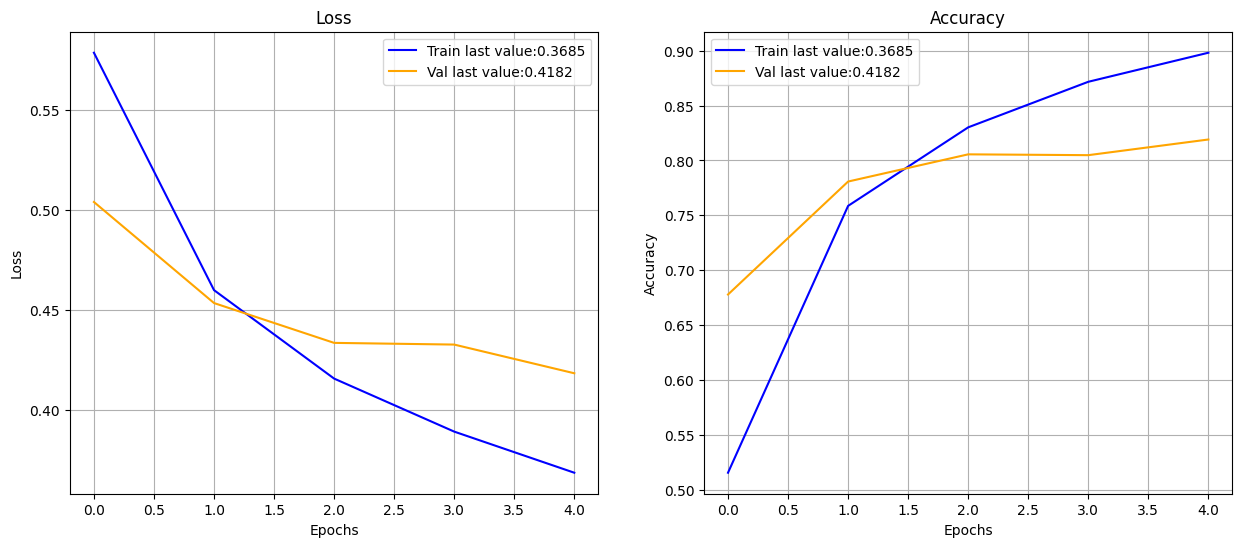

In [22]:
plot_loss_acc_list()

## Model 3: CNN or LSTM with BERT

Please follow the architecture for model2 to construct a CNN or an LSTM model on the top of BERT.

In [23]:
import gc
if 'model' in locals():
  del model
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [29]:
class LSTM_BERT(nn.Module):
    """
    Task 3: Advanced classifier using BERT:

    Begin
    """

    def __init__(self, lstm_hidden_size=100):
        super(LSTM_BERT, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        #freezing BERT parameters so they dont get fine-tuned
        for param in self.bert.parameters():
            param.requires_grad = False
        #LSTM
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm = nn.LSTM(input_size=768, hidden_size=self.lstm_hidden_size,batch_first=True, bidirectional=False)
        #outout for 3 classes
        self.fc = nn.Linear(self.lstm_hidden_size, 3)


    def forward(self, input_ids, attention_mask):
        #extract BERT embeddings (last hidden states)
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        embeddings = bert_output.last_hidden_state

        # LSTM
        lstm_output, _ = self.lstm(embeddings)

        #classification from output
        lstm_final = lstm_output[:, -1, :]
        #return class probabilities
        return torch.softmax(self.fc(lstm_final), dim=1)


    """
    End Task 3
    """


model = LSTM_BERT()
model.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [30]:
print(model)

LSTM_BERT(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_fe

In [31]:
epochs = 5
batch_size = 256

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=False)

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/5, Train Loss: 1.0845, Train Acc: 0.4395, Val Loss: 1.0706, Val Acc: 0.4535
Epoch 2/5, Train Loss: 1.0648, Train Acc: 0.4507, Val Loss: 1.0564, Val Acc: 0.4535
Epoch 3/5, Train Loss: 1.0546, Train Acc: 0.4507, Val Loss: 1.0455, Val Acc: 0.4535
Epoch 4/5, Train Loss: 1.0428, Train Acc: 0.4593, Val Loss: 1.0287, Val Acc: 0.4925
Epoch 5/5, Train Loss: 1.0278, Train Acc: 0.4850, Val Loss: 1.0132, Val Acc: 0.5128


In [32]:
# eval
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 1.0156, Test Acc: 0.5105


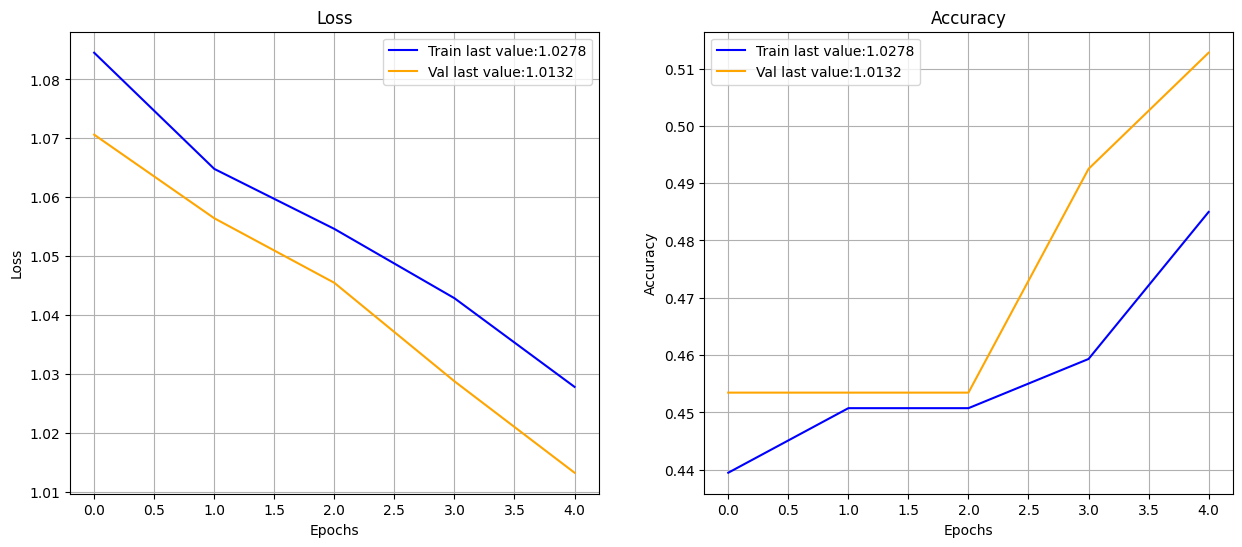

In [33]:
plot_loss_acc_list()